In [11]:
%matplotlib inline

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.statespace.varmax import VARMAX
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sktime.performance_metrics.forecasting import smape_loss, mase_loss
import pmdarima

# Applications of VAR modeling on macroeconomic data

Vector Autoregressive models are primarily used with econometric data. Therefore we will explore various applications of VAR models on the statsmodels dataset: United States Macroeconomic data
source:https://www.statsmodels.org/0.6.1/datasets/generated/macrodata.html

### Pull in the dataset

In [12]:
macrodata = sm.datasets.macrodata.load_pandas().data
macrodata.index = pd.period_range('1959Q1', '2009Q3', freq='Q')

macrodata.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
1959Q1,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1959Q2,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
1959Q3,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
1959Q4,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
1960Q1,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


### Consider only GDP (realgdp) and personal consumption expenditures (realcons)

PCE is one of the major engines of growth and should influence GDP, we will see if this is reflected in the data

In [13]:
df=macrodata[['realgdp','realcons']][:-12]

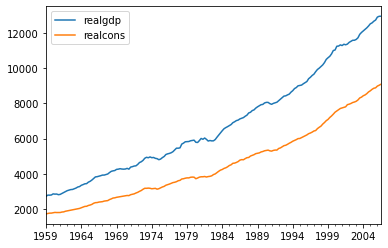

In [14]:
df.plot()
plt.show()

The time series are not stationary. Fitting a VAR model on non-stationary data is called VAR in differences. So first we must difference the data

In [15]:
df_diff = df.diff(1).dropna()

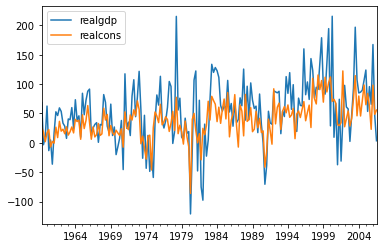

In [16]:
df_diff.plot()
plt.show()

In [17]:
# Split into train and test
train = df_diff[:-12]
test = df_diff[-12:]

# VAR

In [18]:
from statsmodels.tsa.vector_ar.var_model import VAR

var_model = VAR(macrodata[['realgdp','realcons']]).fit()
yhat = var_model.forecast(var_model.endog, steps=1)
print(yhat)

[[13052.67967128  9295.48115011]]


In [19]:
var_model=VAR(train)

results_aic =[]
for p in range(1,10):
    results = var_model.fit(p)
    results_aic.append(results.aic)

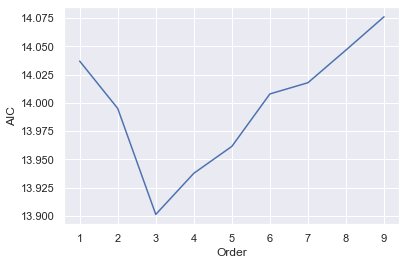

In [20]:
import seaborn as sns
sns.set()
plt.plot(list(np.arange(1,10,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

Here we can see that the lowest AIC score is achieved at order of 3. Then AIC increases afterwards. We should fit a VAR(3)model. When coding in R, can use the function VARselect().

The textbook recommends that we use BIC to find the VAR order. Let's try that to see if there is a difference

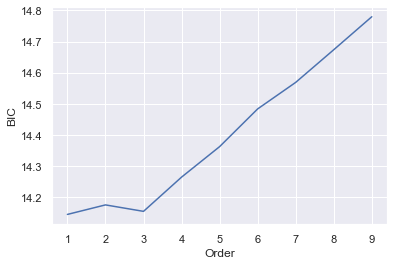

In [21]:
results_bic =[]
for p in range(1,10):
    results = var_model.fit(p)
    results_bic.append(results.bic)
    

plt.plot(list(np.arange(1,10,1)), results_bic)
plt.xlabel("Order")
plt.ylabel("BIC")
plt.show()

It is close. However, let's just go with the simpler model. We will fit a VAR(1) model since there are less parameters to estimate than by using AIC

In [22]:
results = var_model.fit(1)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 18, May, 2021
Time:                     08:29:01
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    14.1445
Nobs:                     177.000    HQIC:                   14.0805
Log likelihood:          -1738.57    FPE:                1.24777e+06
AIC:                      14.0369    Det(Omega_mle):     1.20653e+06
--------------------------------------------------------------------
Results for equation realgdp
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const              18.038131         5.523659            3.266           0.001
L1.realgdp         -0.025913         0.085298           -0.304           0.761
L1.realcons         0.954927         0.147467            6.476    

We see summary information, like our different Information Criteria
- AIC Alkaike Information Criterion
- BIC Bayesian Information Criterion
- HQIC Hanna-Quinn Information Criterion  
- FPE Final Prediction Error

More information about order selection criteria: https://econwpa.ub.uni-muenchen.de/econ-wp/comp/papers/0404/0404001.pdf

Also the coefficients with theri standard errors, t-statistics and p-values for both equations ( one for gdp and one for pce)

Finally the correlation matrix of residuals

### Forecasting using our VAR model

In [23]:
yhat = results.forecast(var_model.endog, steps=12)

In [24]:
test.index

PeriodIndex(['2003Q4', '2004Q1', '2004Q2', '2004Q3', '2004Q4', '2005Q1',
             '2005Q2', '2005Q3', '2005Q4', '2006Q1', '2006Q2', '2006Q3'],
            dtype='period[Q-DEC]', freq='Q-DEC')

In [25]:
# clean up yhat
idx=test.index
df_preds = pd.DataFrame(yhat).set_index(idx)
df_preds.columns =[['realgdp_forecast', 'realcons_forecast']]

In [26]:
df_preds

,realgdp_forecast,realcons_forecast
2003Q4,122.087861,74.604381
2004Q1,86.116261,55.451057
2004Q2,68.758351,46.213333
2004Q3,60.386788,41.757344
2004Q4,56.348572,39.608007
2005Q1,54.400753,38.571265
2005Q2,53.461213,38.071190
2005Q3,53.008024,37.829977
2005Q4,52.789426,37.713627
2006Q1,52.683985,37.657505


<AxesSubplot:>

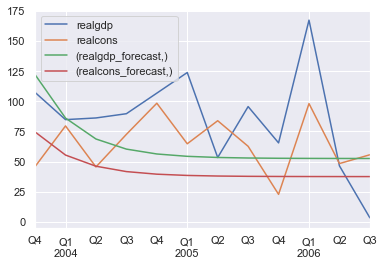

In [27]:
df_results = pd.concat([test,df_preds], axis=1)
df_results.plot()

The units don't look right, we differenced our data, so we need to tranform back to the original units

- Align column names
- Add last row of train set(non-differenced) to the differenced predictions
- run cumulative sum to add back the differences and arrive in the correct units
- clean up (drop extra rows and adjust index to dates)

In [28]:
df_preds.columns = df.columns
# df_preds

In [10]:
pd.concat([df[-13:-12],df_preds], axis=0)

NameError: name 'df_preds' is not defined

In [19]:
forecast_results = pd.concat([df[-13:-12],df_preds], axis=0).reset_index(drop=True)\
                    .cumsum()\
                    .drop([0])\
                    .set_index(idx)
forecast_results.columns=['gdp_forecast','cons_forecast']

In [20]:
forecast_results

,gdp_forecast,cons_forecast
2003Q4,12057.548861,8386.704381
2004Q1,12143.665122,8442.155438
2004Q2,12212.423473,8488.368771
2004Q3,12272.810262,8530.126115
2004Q4,12329.158834,8569.734122
2005Q1,12383.559587,8608.305387
2005Q2,12437.020800,8646.376577
2005Q3,12490.028824,8684.206553
2005Q4,12542.818250,8721.920180
2006Q1,12595.502235,8759.577686


In [48]:
pd.concat([df.realgdp[-13:-12],df_preds.realgdp], axis=0)

2003Q3    11935.461000
2003Q4      122.087861
2004Q1       86.116261
2004Q2       68.758351
2004Q3       60.386788
2004Q4       56.348572
2005Q1       54.400753
2005Q2       53.461213
2005Q3       53.008024
2005Q4       52.789426
2006Q1       52.683985
2006Q2       52.633125
2006Q3       52.608593
Freq: Q-DEC, Name: realgdp, dtype: float64

In [45]:
fr = pd.concat([df.realgdp[-13:-12],df_preds.realgdp], axis=0).cumsum()
fr.columns=['gdp_forecast']
fr

2003Q3    11935.461000
2003Q4    12057.548861
2004Q1    12143.665122
2004Q2    12212.423473
2004Q3    12272.810262
2004Q4    12329.158834
2005Q1    12383.559587
2005Q2    12437.020800
2005Q3    12490.028824
2005Q4    12542.818250
2006Q1    12595.502235
2006Q2    12648.135360
2006Q3    12700.743953
Freq: Q-DEC, Name: realgdp, dtype: float64

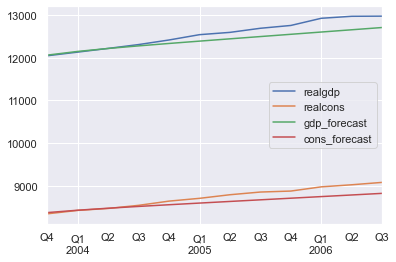

In [18]:
final_results = pd.concat([df[-12:],forecast_results], axis=1)
final_results.plot()
plt.show()

In [19]:
print('VAR real GDP RMSE: ' + str(sqrt(mean_squared_error(final_results['realgdp'],final_results['gdp_forecast']))))
print('VAR real PCE RMSE: ' + str(sqrt(mean_squared_error(final_results['realcons'],final_results['cons_forecast']))))

VAR real GDP RMSE: 183.66690701472223
VAR real PCE RMSE: 152.65052972273153


# VMA

Lets fit with a Vector moving average model. Examine BIC results to determine order of best fit

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximu

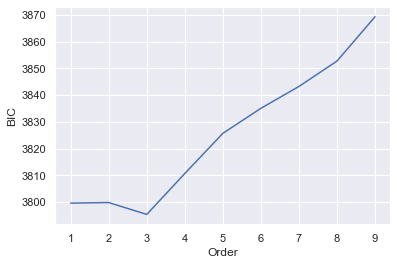

In [20]:
results_bic =[]
for q in range(1,10):
    model = VARMAX(df_diff[['realgdp','realcons']], order= (0,q))
    results = model.fit(maxiter=200, disp=False)
    results_bic.append(results.bic)
    

plt.plot(list(np.arange(1,10,1)), results_bic)
plt.xlabel("Order")
plt.ylabel("BIC")
plt.show()

In [21]:
vma_model = VARMAX(df_diff[['realgdp','realcons']], order= (0,3))
results = vma_model.fit(maxiter=1000, disp=False)

In [22]:
results.summary()

Dep. Variable:,"['realgdp', 'realcons']",No. Observations:,190
Model:,VMA(3),Log Likelihood,-1853.080
,+ intercept,AIC,3740.160
Date:,"Wed, 05 May 2021",BIC,3795.360
Time:,08:43:08,HQIC,3762.521
Sample:,06-30-1959,,
,- 09-30-2006,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.00, 0.04",Jarque-Bera (JB):,"5.58, 14.02"
Prob(Q):,"0.98, 0.85",Prob(JB):,"0.06, 0.00"
Heteroskedasticity (H):,"1.65, 2.43",Skew:,"0.16, 0.39"


### Forecasting using our VMA model



In [23]:
yhat = results.forecast(steps=12)

In [24]:
# clean up yhat
idx=test.index
df_preds = pd.DataFrame(yhat).set_index(idx)
df_preds.columns =[['realgdp_forecast', 'realcons_forecast']]

In [25]:
df_preds.columns = df.columns

In [26]:
forecast_results = pd.concat([df[-13:-12],df_preds], axis=0).reset_index(drop=True)\
                    .cumsum()\
                    .drop([0])\
                    .set_index(idx)
forecast_results.columns=['gdp_forecast','cons_forecast']

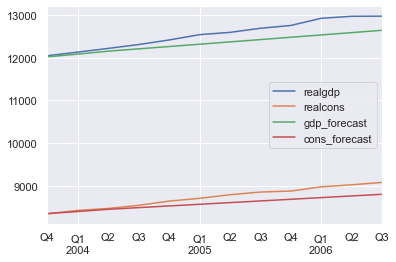

In [27]:
final_results = pd.concat([df[-12:],forecast_results], axis=1)
final_results.plot()
plt.show()

In [28]:
print('VMA real GDP RMSE: ' + str(sqrt(mean_squared_error(final_results['realgdp'],final_results['gdp_forecast']))))
print('VMA real PCE RMSE: ' + str(sqrt(mean_squared_error(final_results['realcons'],final_results['cons_forecast']))))

VMA real GDP RMSE: 239.53472984616914
VMA real PCE RMSE: 172.5786950786537


# VARMA

In [29]:
from statsmodels.tsa.statespace.varmax import VARMAX

varma_model = VARMAX(df_diff[['realgdp','realcons']], order=(1, 1)).fit(disp=False)
yhat = varma_model.forecast(steps=1)
print(yhat)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


          realgdp   realcons
2006Q4  82.874462  52.344728


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [30]:
varma_model.summary()

Dep. Variable:,"['realgdp', 'realcons']",No. Observations:,190
Model:,"VARMA(1,1)",Log Likelihood,-1852.108
,+ intercept,AIC,3730.215
Date:,"Wed, 05 May 2021",BIC,3772.427
Time:,08:43:09,HQIC,3747.314
Sample:,06-30-1959,,
,- 09-30-2006,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.01, 0.22",Jarque-Bera (JB):,"8.15, 18.02"
Prob(Q):,"0.90, 0.64",Prob(JB):,"0.02, 0.00"
Heteroskedasticity (H):,"2.05, 2.27",Skew:,"0.05, 0.41"


In [31]:
yhat = varma_model.forecast(steps=12)

In [33]:
# clean up yhat
idx=test.index
df_preds = pd.DataFrame(yhat).set_index(idx)
df_preds.columns =[['realgdp_forecast', 'realcons_forecast']]

In [34]:
df_preds.columns = df.columns

In [35]:
forecast_results = pd.concat([df[-13:-12],df_preds], axis=0).reset_index(drop=True)\
                    .cumsum()\
                    .drop([0])\
                    .set_index(idx)
forecast_results.columns=['gdp_forecast','cons_forecast']

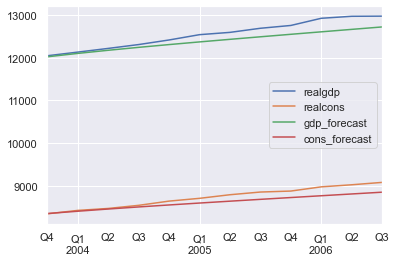

In [36]:
final_results = pd.concat([df[-12:],forecast_results], axis=1)
final_results.plot()
plt.show()

In [37]:
print('VMA real GDP RMSE: ' + str(sqrt(mean_squared_error(final_results['realgdp'],final_results['gdp_forecast']))))
print('VMA real PCE RMSE: ' + str(sqrt(mean_squared_error(final_results['realcons'],final_results['cons_forecast']))))

VMA real GDP RMSE: 185.24513904211065
VMA real PCE RMSE: 140.71233793102726
